In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import importlib
import os
from tqdm.notebook import tqdm
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
import matplotlib as mpl
plt.style.use(['dark_background'])
mpl.rcParams['axes.facecolor'] = (27/256, 27/256, 27/256)
mpl.rcParams['figure.facecolor'] = (27/256, 27/256, 27/256)
mpl.rcParams['legend.facecolor'] = (50/256, 50/256, 50/256)
mpl.rcParams['savefig.facecolor'] = (27/256, 27/256, 27/256)

In [5]:
device = torch.device('cuda:0')

In [6]:
torch.cuda.get_device_name(torch.device('cuda:0'))

'GeForce RTX 2070 SUPER'

In [7]:
model_path = "2021-10-28_18h-29m-00s"
model_version = "checkpoints/model-50"

spec = importlib.util.spec_from_file_location("msi_ebm_copy", "experiments_msi/" + model_path + "/msi_ebm_copy.py")
ebm = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ebm)
sample_langevin = ebm.sample_langevin
sample_langevin_cuda = ebm.sample_langevin_cuda
ReplayBuffer = ebm.ReplayBuffer
model = ebm.NeuralNet().to(device)
ckpt = torch.load("experiments_msi/" + model_path + "/" + model_version + ".pt")
model.load_state_dict(ckpt['model_state_dict'], strict=False)
# data = torch.tensor(np.load("data/isat_downsampled_8_div3.npz")['arr_0'].reshape(-1, 10)).float()

data_path = "data/data-MSI-hairpin_001.npz"
data = ebm.load_data(data_path)
mean = np.load(data_path)['mean']
ptp = np.load(data_path)['ptp']

replay_buffer = ReplayBuffer(ckpt['replay_buffer_list'].shape[0], np.random.randn(*data.shape))
replay_buffer.sample_list = ckpt['replay_buffer_list']
print("Number of parameters: {}".format(np.sum([p.numel() for p in model.parameters() if p.requires_grad])))

Number of parameters: 904801


In [8]:
n_samp = 8192
step_size = 1e2
steps = 100

rand_num = torch.randn((n_samp, 1715), requires_grad=True)
data.requires_grad=True
# torch.tensor(replay_buffer.sample_list[0:n_samp], requires_grad=True).float()

temp_buffer = ReplayBuffer(8192, torch.randn((8192, 1715)).to(device))
for i in tqdm(range(100)):
    buf_samp = temp_buffer.sample(int(256 * 0.98))
    buf_rand = torch.randn((256 - buf_samp.shape[0], 1715)).to(device)
    buf_samp = torch.cat([buf_samp, buf_rand], 0).to(device)
    buf_samp = buf_samp.requires_grad_()
    samples = sample_langevin_cuda(buf_samp, model, step_size=step_size, sample_steps=steps, noise_scale=0.005)
#     samples = sample_langevin(buf_samp, model, step_size=step_size, sample_steps=steps, noise_scale=0.005)
    temp_buffer.add(samples)
samples = sample_langevin_cuda(temp_buffer.sample_list.requires_grad_(), model, step_size=step_size,
                          sample_steps=1, noise_scale=0.005)
# samples = sample_langevin(temp_buffer.sample_list.requires_grad_(), model, step_size=step_size,
#                           sample_steps=1, noise_scale=0.005)
# temp_buffer.add(samples)
# buf_samp = temp_buffer.sample(n_samp)
buf_samp = samples[:n_samp].detach().cpu().numpy()

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
np.savez("samples/" + model_path + "--" + model_version[12:] + "--iter-{}_steps-{}".format(i, steps), buf_samp=samples.detach().cpu().numpy())

In [15]:
buf_samp = np.load("samples/2021-10-28_18h-29m-00s--model-25--iter-99_steps-100.npz")['buf_samp']

In [10]:
data_color = (0.2, 0.7, 1.0, 1.0)
samp_color = (1.0, 0.7, 0.1, 0.6)

<IPython.core.display.Javascript object>


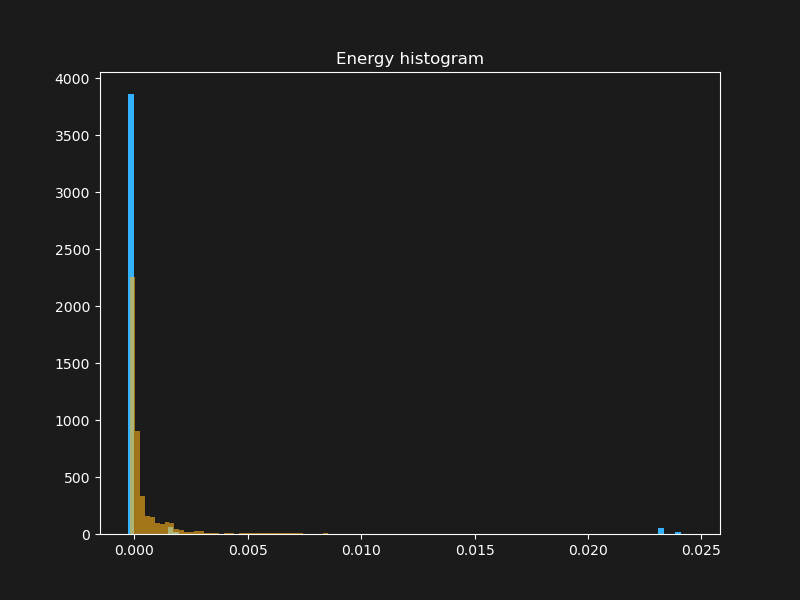

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(8,6))
plt.title('Energy histogram')
axes.hist(model(data[np.random.randint(0, data.shape[0], 2000)].to(device)).to('cpu').detach().numpy(),
          bins=100, density=True, color=data_color);
# axes.hist(model(torch.Tensor(replay_buffer.sample_list[:400]).to(device)).detach().numpy(), bins=100, density=True,
#                color=(0, 0.9, 0.0, 0.6));
axes.hist(model(torch.tensor(buf_samp, device=device)).to('cpu').detach().numpy(), bins=100, density=True,
               color=samp_color);
plt.savefig("experiments_msi/" + model_path + '/energy_hist.png', facecolor=(27/256, 27/256, 27/256))

<IPython.core.display.Javascript object>


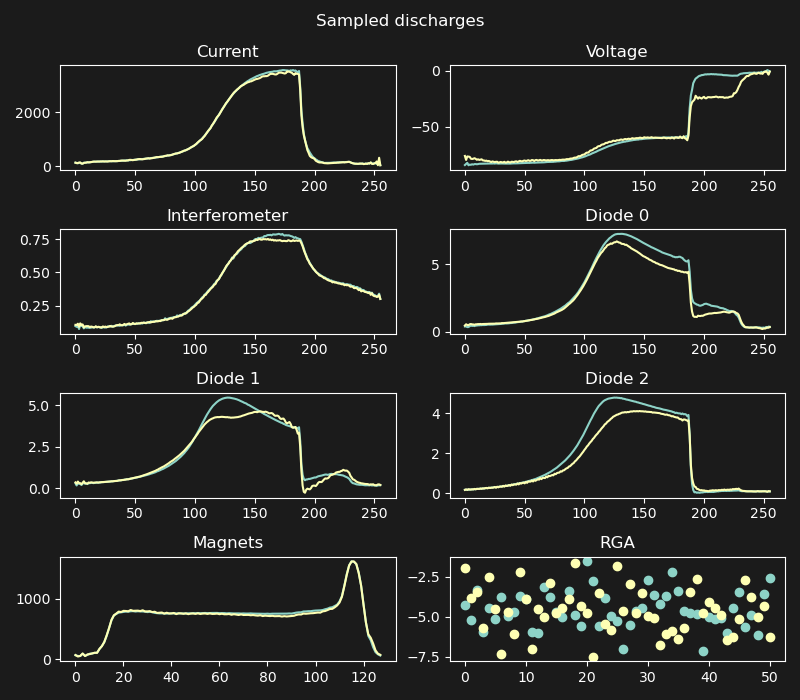

In [17]:
idx = 0
fig, axes = plt.subplots(4,2, figsize=(8,7))
axes[0, 0].plot(buf_samp[idx, 256 * 0:256 * 1] * ptp[0] + mean[0])
axes[0, 1].plot(buf_samp[idx, 256 * 1:256 * 2] * ptp[1] + mean[1])
axes[1, 0].plot(buf_samp[idx, 256 * 2:256 * 3] * ptp[2] + mean[2])
axes[1, 1].plot(buf_samp[idx, 256 * 3:256 * 4] * ptp[3] + mean[3])
axes[2, 0].plot(buf_samp[idx, 256 * 4:256 * 5] * ptp[4] + mean[4])
axes[2, 1].plot(buf_samp[idx, 256 * 5:256 * 6] * ptp[5] + mean[5])
axes[3, 0].plot(buf_samp[idx, 256 * 6:256 * 6 + 128] * ptp[6] + mean[6])
axes[3, 1].scatter(np.arange(51), buf_samp[idx, -51:] * ptp[7] + mean[7])

idx = 2000
axes[0, 0].plot(buf_samp[idx, 256 * 0:256 * 1] * ptp[0] + mean[0])
axes[0, 1].plot(buf_samp[idx, 256 * 1:256 * 2] * ptp[1] + mean[1])
axes[1, 0].plot(buf_samp[idx, 256 * 2:256 * 3] * ptp[2] + mean[2])
axes[1, 1].plot(buf_samp[idx, 256 * 3:256 * 4] * ptp[3] + mean[3])
axes[2, 0].plot(buf_samp[idx, 256 * 4:256 * 5] * ptp[4] + mean[4])
axes[2, 1].plot(buf_samp[idx, 256 * 5:256 * 6] * ptp[5] + mean[5])
axes[3, 0].plot(buf_samp[idx, 256 * 6:256 * 6 + 128] * ptp[6] + mean[6])
axes[3, 1].scatter(np.arange(51), buf_samp[idx, -51:] * ptp[7] + mean[7])

axes[0, 0].set_title('Current')
axes[0, 1].set_title('Voltage')
axes[1, 0].set_title('Interferometer')
axes[1, 1].set_title('Diode 0')
axes[2, 0].set_title('Diode 1')
axes[2, 1].set_title('Diode 2')
axes[3, 0].set_title('Magnets')
axes[3, 1].set_title('RGA')
plt.suptitle("Sampled discharges")
plt.tight_layout()
plt.savefig("experiments_msi/" + model_path + '/example_discharge.png', facecolor=(27/256, 27/256, 27/256))

In [37]:
idx = 0
fig, axes = plt.subplots(4,2, figsize=(8,7))
axes[0, 0].plot(data[idx, 256 * 0:256 * 1].detach().numpy() * ptp[0] + mean[0])
axes[0, 1].plot(data[idx, 256 * 1:256 * 2].detach().numpy() * ptp[1] + mean[1])
axes[1, 0].plot(data[idx, 256 * 2:256 * 3].detach().numpy() * ptp[2] + mean[2])
axes[1, 1].plot(data[idx, 256 * 3:256 * 4].detach().numpy() * ptp[3] + mean[3])
axes[2, 0].plot(data[idx, 256 * 4:256 * 5].detach().numpy() * ptp[4] + mean[4])
axes[2, 1].plot(data[idx, 256 * 5:256 * 6].detach().numpy() * ptp[5] + mean[5])
axes[3, 0].plot(data[idx, 256 * 6:256 * 6 + 128].detach().numpy() * ptp[6] + mean[6])
axes[3, 1].scatter(np.arange(51), data[idx, -51:].detach().numpy() * ptp[7] + mean[7])

idx = 105
axes[0, 0].plot(data[idx, 256 * 0:256 * 1].detach().numpy() * ptp[0] + mean[0])
axes[0, 1].plot(data[idx, 256 * 1:256 * 2].detach().numpy() * ptp[1] + mean[1])
axes[1, 0].plot(data[idx, 256 * 2:256 * 3].detach().numpy() * ptp[2] + mean[2])
axes[1, 1].plot(data[idx, 256 * 3:256 * 4].detach().numpy() * ptp[3] + mean[3])
axes[2, 0].plot(data[idx, 256 * 4:256 * 5].detach().numpy() * ptp[4] + mean[4])
axes[2, 1].plot(data[idx, 256 * 5:256 * 6].detach().numpy() * ptp[5] + mean[5])
axes[3, 0].plot(data[idx, 256 * 6:256 * 6 + 128].detach().numpy() * ptp[6] + mean[6])
axes[3, 1].scatter(np.arange(51), data[idx, -51:].detach().numpy() * ptp[7] + mean[7])

axes[0, 0].set_title('Current')
axes[0, 1].set_title('Voltage')
axes[1, 0].set_title('Interferometer')
axes[1, 1].set_title('Diode 0')
axes[2, 0].set_title('Diode 1')
axes[2, 1].set_title('Diode 2')
axes[3, 0].set_title('Magnets')
axes[3, 1].set_title('RGA')
plt.suptitle("Real discharges")
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


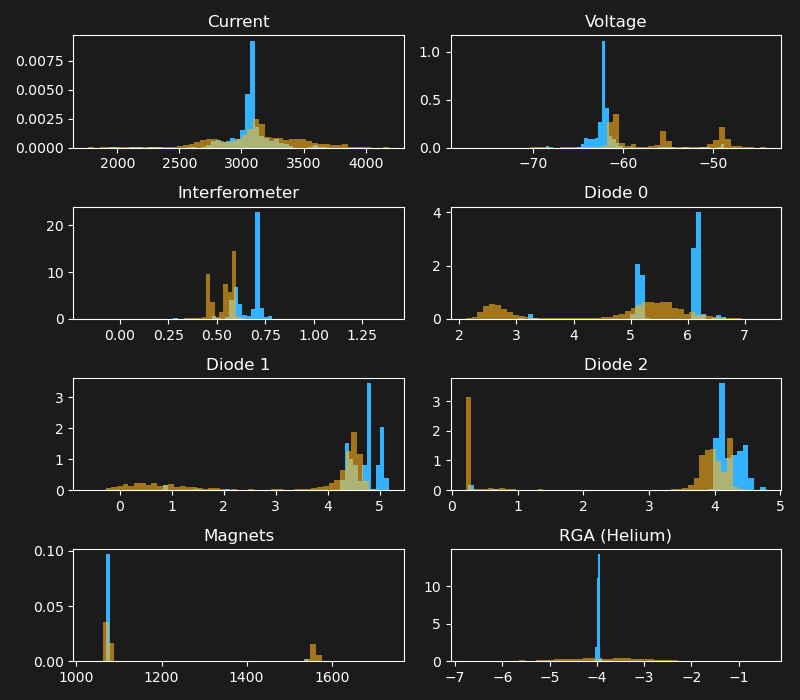

In [13]:
n_bins = 51

fig, axes = plt.subplots(4,2, figsize=(8,7))
axes[0, 0].hist(np.mean(data[:, 256 * 0:256 * 1].detach().numpy()[:, 133:183], axis=1) * ptp[0] + mean[0], bins=n_bins, density=True, color=data_color)
axes[0, 1].hist(np.mean(data[:, 256 * 1:256 * 2].detach().numpy()[:, 133:183], axis=1) * ptp[1] + mean[1], bins=n_bins, density=True, color=data_color)
axes[1, 0].hist(np.mean(data[:, 256 * 2:256 * 3].detach().numpy()[:, 133:183], axis=1) * ptp[2] + mean[2], bins=n_bins, density=True, color=data_color)
axes[1, 1].hist(np.mean(data[:, 256 * 3:256 * 4].detach().numpy()[:, 133:183], axis=1) * ptp[3] + mean[3], bins=n_bins, density=True, color=data_color)
axes[2, 0].hist(np.mean(data[:, 256 * 4:256 * 5].detach().numpy()[:, 133:183], axis=1) * ptp[4] + mean[4], bins=n_bins, density=True, color=data_color)
axes[2, 1].hist(np.mean(data[:, 256 * 5:256 * 6].detach().numpy()[:, 133:183], axis=1) * ptp[5] + mean[5], bins=n_bins, density=True, color=data_color)
axes[3, 0].hist(np.std(data[:, 256 * 6:256 * 6 + 128].detach().numpy(), axis=1) * ptp[6] + mean[6], bins=n_bins, density=True, color=data_color)
axes[3, 1].hist(data[:, 1715-51+4].detach().numpy() * ptp[7] + mean[7], bins=n_bins, density=True, color=data_color)


axes[0, 0].hist(np.mean(buf_samp[:, 256 * 0:256 * 1][:, 133:183], axis=1) * ptp[0] + mean[0], bins=n_bins, density=True, color=samp_color)
axes[0, 1].hist(np.mean(buf_samp[:, 256 * 1:256 * 2][:, 133:183], axis=1) * ptp[1] + mean[1], bins=n_bins, density=True, color=samp_color)
axes[1, 0].hist(np.mean(buf_samp[:, 256 * 2:256 * 3][:, 133:183], axis=1) * ptp[2] + mean[2], bins=n_bins, density=True, color=samp_color)
axes[1, 1].hist(np.mean(buf_samp[:, 256 * 3:256 * 4][:, 133:183], axis=1) * ptp[3] + mean[3], bins=n_bins, density=True, color=samp_color)
axes[2, 0].hist(np.mean(buf_samp[:, 256 * 4:256 * 5][:, 133:183], axis=1) * ptp[4] + mean[4], bins=n_bins, density=True, color=samp_color)
axes[2, 1].hist(np.mean(buf_samp[:, 256 * 5:256 * 6][:, 133:183], axis=1) * ptp[5] + mean[5], bins=n_bins, density=True, color=samp_color)
axes[3, 0].hist(np.std(buf_samp[:, 256 * 6:256 * 6 + 128], axis=1) * ptp[6] + mean[6], bins=n_bins, density=True, color=samp_color)
axes[3, 1].hist(buf_samp[:, 1715-51+4] * ptp[7] + mean[7], bins=n_bins, density=True, color=samp_color)


axes[0, 0].set_title('Current')
axes[0, 1].set_title('Voltage')
axes[1, 0].set_title('Interferometer')
axes[1, 1].set_title('Diode 0')
axes[2, 0].set_title('Diode 1')
axes[2, 1].set_title('Diode 2')
axes[3, 0].set_title('Magnets')
axes[3, 1].set_title('RGA (Helium)')
plt.tight_layout()

<IPython.core.display.Javascript object>


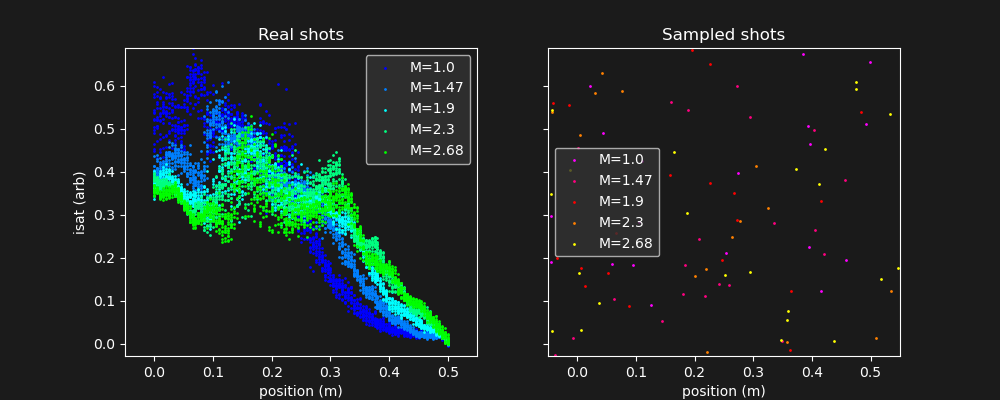

In [68]:
n_samp_cond = 300
cndstp = 1e-2
cnd_stps = 120

data.requires_grad=True

range_nums = [0, 1, 2, 3, 4]

rand_nums = []
B_fields = [1/3, 1.47/3, 1.9/3, 2.3/3, 2.68/3]
for i in range(5):
    rand_nums.append(torch.cat((torch.randn((n_samp_cond, 1)),
                      torch.randn((n_samp_cond, 1))*0+B_fields[i],
                      torch.randn((n_samp_cond, 8), requires_grad=True)), 1))
samples_cond = []
for i in range(5):
    samples_cond.append(sample_langevin(rand_nums[i].cuda()[0:n_samp_cond],
                          model, step_size=torch.Tensor([cndstp, 0, cndstp, cndstp, cndstp, cndstp,
                                                         cndstp, cndstp, cndstp, cndstp]).cuda(),
                          sample_steps=cnd_stps, noise_scale=0.01, return_list=False))

# for i in range(len(samples)):
#     samples[i].cpu()

t_ini = 2
t_end = 3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)
# ax = plt.axes()

# data_colors = [(0, 0, 1, 0.8), (0, 0.3, 1.0, 0.8), (0, 0.5, 1.0, 0.8), (0, 0.7, 0.7, 0.8), (0, 1.0, 0, 0.8)]
data_colors = [mpl.colors.hsv_to_rgb((4/6, 1, 1)), mpl.colors.hsv_to_rgb((3.5/6, 1, 1)),
               mpl.colors.hsv_to_rgb((3/6, 1, 1)), mpl.colors.hsv_to_rgb((2.5/6, 1, 1)),
               mpl.colors.hsv_to_rgb((2/6, 1, 1))]
# samp_colors = [(1.0, 0.0, 0.8, 1.0), (1.0, 0.0, 0.4, 1.0), (1.0, 0.0, 0.0, 1.0), (1.0, 0.3, 0.0, 1.0), (1.0, 0.6, 0.0, 1.0)]
samp_colors = [mpl.colors.hsv_to_rgb((5/6, 1, 1)), mpl.colors.hsv_to_rgb((5.5/6, 1, 1)),
               mpl.colors.hsv_to_rgb((6/6, 1, 1)), mpl.colors.hsv_to_rgb((0.5/6, 1, 1)),
               mpl.colors.hsv_to_rgb((1/6, 1, 1))]

datas = []
samps = []
for i in range_nums:
    datas.append(ax1.scatter([], [], s=1, color=data_colors[i], label="M={}".format(B_fields[i]*3)))
#     datas.append(ax.plot([], [], color=data_colors[i], label="M={}, Data".format(B_fields[i]*3)))
for i in range_nums:
    samps.append(ax2.scatter([], [], s=1, color=samp_colors[i], label="M={}".format(B_fields[i]*3)))

# plt.scatter(replay_buffer.sample_list[:400, 0], np.mean(replay_buffer.sample_list[:400, 2:], axis=1), s=1, color='green')

ax1.set_xlim(-0.05, 0.55)
ax1.set_ylim(np.min(data.detach().numpy()[:, 2:]), np.max(data.detach().numpy()[:, 2:]))
ax2.set_xlim(-0.05, 0.55)
ax2.set_ylim(np.min(data.detach().numpy()[:, 2:]), np.max(data.detach().numpy()[:, 2:]))

data_plot_data = (np.mean(data.detach().numpy().reshape(5, 101, 15, 10), axis=2).reshape(-1, 10))
def animate(i):
    for j, k in enumerate(range_nums):
        datas[j].set_offsets(np.hstack((data.detach().numpy()[15*101*k:15*101*(k+1), 0, np.newaxis],
                                    data.detach().numpy()[15*101*k:15*101*(k+1), 2+i, np.newaxis])))
        samps[j].set_offsets(np.hstack((samples_cond[k].cpu().detach().numpy()[:, 0, np.newaxis],
                                samples_cond[k].cpu().detach().numpy()[:, 2+i, np.newaxis])))
                                                        
#         datas[k][0].set_data(data_plot_data[101*k:101*(k+1), 0], data_plot_data[101*k:101*(k+1), 2+i])

fig.set_facecolor((27/256, 27/256, 27/256))
ax1.set_facecolor((26/256, 26/256, 26/256))
ax2.set_facecolor((26/256, 26/256, 26/256))
# plt.title('Time series of sampled and real data for various mirror ratios')
ax1.set_title('Real shots')
ax2.set_title('Sampled shots')
ax1.set_xlabel('position (m)')
ax2.set_xlabel('position (m)')
ax1.set_ylabel('isat (arb)')
ax1.legend()
ax2.legend()

anim = ani.FuncAnimation(fig, animate, frames=8, interval=250, blit=True, repeat=True)
# anim.save('demo_sampling_multiple_split.mp4', savefig_kwargs={'facecolor': (26/256, 26/256, 26/256)})
anim.save("experiments/" + model_path + '/scatter_ani_field.mp4', savefig_kwargs={'facecolor': (27/256, 27/256, 27/256)})























































.